# Import libraries and load in the mnist data

In [1]:
import numpy as np
from PIL import Image
from glob import glob
import os.path as osp
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

In [5]:
def load_data(train_path='train/', test_path='test/'):
    train_list = glob(osp.join(train_path, '*.png'))
    pattern = re.compile(r'num(\d).png')
    train_id = np.array([float(pattern.search(img_name).groups()[0]) for img_name in train_list])
    train_data = np.concatenate([np.array(Image.open(img_name)).reshape((1, 784))for img_name in tqdm_notebook(train_list, leave=False)],
                                axis=0).astype(np.float)

    test_list = glob(osp.join(test_path, '*.png'))
    test_id = np.array([float(pattern.search(img_name).groups()[0]) for img_name in test_list])
    test_data = np.concatenate([np.array(Image.open(img_name)).reshape((1, 784)) for img_name in tqdm_notebook(test_list, leave=False)],
                               axis=0).astype(np.float)

    return train_data, train_id, test_data, test_id

In [6]:
X, y, X_test, y_test = load_data()

In [4]:
X.shape

(60000, 784)

In [5]:
X_test.shape

(10000, 784)

In [6]:
y

array([8., 7., 4., ..., 2., 3., 6.])

### Look at the data

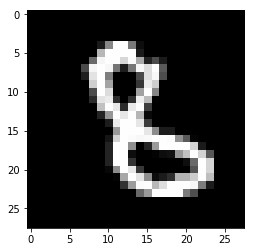

In [7]:
plt.imshow(X[0].reshape((28, 28)), cmap='gray')
plt.show()

In [8]:
X[0].reshape((28, 28))

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  26., 136.,
        255., 255., 121.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

#### Normalize our data by MinMax Scaler

Which is, to divide every pixel by 255

In [9]:
X /= 255
X_test /= 255

#### Split the data into mini-batches

In [10]:
# feed 128 examples to network at a time
batch_size = 128

In [11]:
X_mini_batches = [X[k:k+batch_size] for k in range(0, len(X), batch_size)]
y_mini_batches = [y[k:k+batch_size] for k in range(0, len(y), batch_size)]

In [12]:
X_mini_batches[0].shape, X_mini_batches[-1].shape

((128, 784), (96, 784))

In [13]:
y_mini_batches[0].shape, y_mini_batches[-1].shape

((128,), (96,))

In [14]:
len(X_mini_batches), len(y_mini_batches)

(469, 469)

# Start building a SoftMax Classifier

In [15]:
# initialize parameters randomly
W = 0.01 * np.random.randn(784, 10)
b = np.zeros((1, 10))

## Forward Pass
Compute Class scores
$$
y_i=Wx_i+b
$$
Use SoftMax to convert from scores to probs
$$
p_{i,j}=\frac{e^{y_{i,j}}}{\sum_{k}e^{y_{i,k}}}
$$

In [16]:
# We are gonna use the first mini batch for demo
X_batch, y_batch = X_mini_batches[0], y_mini_batches[0]

In [17]:
# compute class scores for a linear classifier
scores = np.dot(X_batch, W) + b
num_examples = X_batch.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Compute the loss
Classification loss:
$$
L_i=-\sum_{j}t_{i,j}log(p_{i,j})
$$
Regularization loss:
$$
L_{reg}=\frac{1}{2}\lambda \|W\|^2
$$
Over all loss:
$$
L=\frac{1}{N}\sum_{i}L_i+\frac{1}{2}\lambda \|W\|^2
$$

In [18]:
correct_logprobs = -np.log(probs[range(num_examples), y_batch.astype(np.int)])

In [19]:
reg = 1e-3

In [20]:
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs) / num_examples
reg_loss = 0.5 * reg * np.sum(W * W)
loss = data_loss + reg_loss

In [21]:
loss

2.2928781582963933

## Backward Pass
$$
\frac{\partial L_i}{\partial y_i}=p_i-t_i
$$
By apply the chain rule
$$
\frac{\partial L_i}{\partial W}=\frac{\partial L_i}{\partial y_i}\frac{\partial y_i}{\partial W}
=\frac{\partial L_i}{\partial y_i}x_i\\
$$


$$
\frac{\partial L_i}{\partial b}=\frac{\partial L_i}{\partial y_i}\frac{\partial y_i}{\partial b}
=\frac{\partial L_i}{\partial y_i}
$$
And the regularization term
$$
\frac{\partial }{\partial W} (\frac{1}{2}\lambda \|W\|^2)=\lambda W
$$

In [22]:
dscores = probs
dscores[range(num_examples), y_batch.astype(np.int)] -= 1
dscores /= num_examples

In [23]:
dW = np.dot(X_batch.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg * W # don't forget the regularization gradient

#### Update parameter

In [24]:
# perform a parameter update
W += -0.01 * dW
b += -0.01 * db

#### Form a training loop

In [25]:
W = 0.01 * np.random.randn(784,10)
b = np.zeros((1,10))

In [26]:
step_size = 1e-0
reg = 1e-3

In [27]:
# define some function to increase readibility
def forward(W, b, reg, X_batch, y_batch):
    # Forward pass
    num_examples = X_batch.shape[0]
    scores = np.dot(X_batch, W) + b
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Compute loss
    correct_logprobs = -np.log(probs[range(num_examples), y_batch.astype(np.int)])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    return loss, probs

In [28]:
def backward(W, b, reg, X_batch, y_batch, probs):
    num_examples = X_batch.shape[0]
    # Backward Pass
    dscores = probs
    dscores[range(num_examples), y_batch.astype(np.int)] -= 1
    dscores /= num_examples
    dW = np.dot(X_batch.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg * W # regularization gradient
    return dW, db

In [29]:
for i in tqdm_notebook(range(50)):
    for idx, (X_batch, y_batch) in enumerate(zip(X_mini_batches, y_mini_batches)):
        loss, probs = forward(W, b, reg, X_batch, y_batch)
        if i % 10 == 0 and idx == 0:
            print("iteration %d: loss %f" % (i, loss))
  
        dW, db = backward(W, b, reg, X_batch, y_batch, probs)

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db

iteration 0: loss 2.307334
iteration 10: loss 0.409535
iteration 20: loss 0.409693
iteration 30: loss 0.409710
iteration 40: loss 0.409712



In [30]:
# evaluate training set accuracy
_, probs = forward(W, b, reg, X, y)
predicted_class = np.argmax(probs, axis=1)
print( 'training accuracy: %.5f' % (np.mean(predicted_class == y)))

training accuracy: 0.90500


In [31]:
# evaluate training set accuracy
_, probs = forward(W, b, reg, X_test, y_test)
predicted_class = np.argmax(probs, axis=1)
print( 'test accuracy: %.5f' % (np.mean(predicted_class == y_test)))

test accuracy: 0.90870


#### SoftMax compared with multiple logistics regression model

Gradient for SoftMax is 
$$
\frac{\partial L_i}{\partial W}=\frac{\partial L_i}{\partial y_i}\frac{\partial y_i}{\partial W}
=\frac{\partial L_i}{\partial y_i}x_i\\
$$


$$
\frac{\partial L_i}{\partial b}=\frac{\partial L_i}{\partial y_i}\frac{\partial y_i}{\partial b}
=\frac{\partial L_i}{\partial y_i}
$$

Where $\frac{\partial L_i}{\partial y_i}$ is
$$
\frac{\partial L_i}{\partial y_i}=p_i-t_i
$$

Gradient for Logistics regression is
$$
\frac{\partial J(\theta)}{\partial \theta}=\sum_{i=1}^{m}(y_{\theta}(x)-t^{(i)})x^{(i)}
$$

So the Gradient for SoftMax and Logistics Regression is actually the same!

One key different is that SoftMax can ensure that probability for every class can add up to 1, while Logistics Regression cannot.

SoftMax is 
$$
p_{i,j}=\frac{e^{y_{i,j}}}{\sum_{k}e^{y_{i,k}}}
$$

Logistics Regression is
$$
y_{\theta_i} = \frac{1}{1+e^{-\theta_i^Tx}}
$$

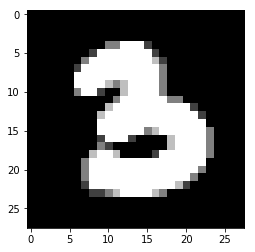

In [32]:
plt.imshow(X_test[0].reshape((28, 28)), cmap='gray')
plt.show()

So SoftMax can force all probs to sum up to 1

In [33]:
np.argmax(probs[0]), np.sum(probs[0])

(3, 1.0000000000000002)

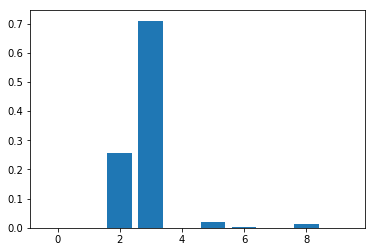

In [34]:
# probs is the probability we get from X_test[0]
plt.bar(range(10), probs[0])
plt.show()

In [35]:
def get_classifier(X_train, y_train, num_epoch=1000, alpha=0.01):
    theta = np.zeros((X_train.shape[1]))
    for epoch in range(num_epoch):
        # forward pass
        logits = np.dot(X_train, theta)
        h = 1 / (1 + np.exp(-logits))
        cross_entropy_loss = (-y_train * np.log(h) - (1 - y_train) * np.log(1 - h)).mean()
    
        # backward pass
        gradient = np.dot((h - y_train), X_train) / y.size
        theta = theta - alpha * gradient
    return theta

def multi_classifier(X_train, y_train):
    num_class = np.unique(y_train)
    param = np.zeros((len(num_class), X_train.shape[1]))
    
    for i in tqdm_notebook(num_class):
        label_t = np.zeros_like(y_train)
        num_class = np.unique(y_train)
        label_t[y_train == num_class[int(i)]] = 1
        param[int(i), :] = get_classifier(X_train, label_t)
    
    return param

In [36]:
W_logistic = multi_classifier(X, y)

In [37]:
np.save('W_logistic.npy', W_logistic)

In [38]:
W_logistic = np.load('W_logistic.npy')

In [39]:
scores = np.dot(X_test[0], W_logistic.T)

In [40]:
scores = 1 / (1 + np.exp(-scores))

In [41]:
np.argmax(scores), np.sum(scores)

(3, 0.11885482362556947)

In [42]:
scores

array([1.48391378e-03, 1.16825283e-04, 7.59152825e-03, 7.85978369e-02,
       5.23101941e-05, 6.91530261e-03, 2.03889932e-02, 2.02595597e-04,
       3.34715722e-03, 1.58360624e-04])

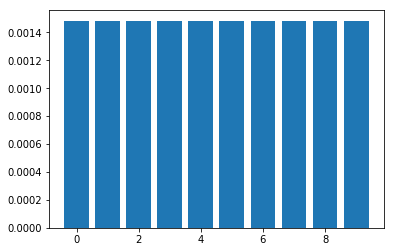

In [43]:
plt.bar(range(10), scores[0])
plt.show()

# Two layer neural network

In [44]:
# initialize parameters randomly
h = 256 # size of hidden layer
W = 0.01 * np.random.randn(784,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,10)
b2 = np.zeros((1,10))

<img src="twolayer.png" style="zoom:50%;" align="middle" />

In [45]:
X_batch, y_batch = X_mini_batches[0], y_mini_batches[0]

#### Two layer neural network as a automatic feature engineering

Picture from the nndl-ebook

<img src="nndl.png" style="zoom:50%;" align="middle"/>

In [46]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X_batch, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

In [47]:
num_examples = X_batch.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

correct_logprobs = -np.log(probs[range(num_examples), y_batch.astype(np.int)])

In [48]:
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs) / num_examples
reg_loss = 0.5 * reg * np.sum(W * W)
loss = data_loss + reg_loss

In [49]:
loss

2.3108377670883447

In [50]:
dscores = probs
dscores[range(num_examples), y_batch.astype(np.int)] -= 1
dscores /= num_examples

In [51]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

#### Backward through ReLU

The other part of the this two layer network is actually the same as before, 
the only difference is the activation function ReLU.

Since $ReLU(x)=max\{0,x\}$, We have that $\frac{dReLU}{dx}=1(x>0)$, so ReLU is like a switch, kills off all the activation below 0.

In [52]:
dhidden = np.dot(dscores, W2.T)
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

In [53]:
# finally into W,b
dW = np.dot(X_batch.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

In [54]:
W += -step_size * dW
b += -step_size * db
W2 += -step_size * dW2
b2 += -step_size * db2

In [55]:
def forward(W, b, W2, b2, reg, X_batch, y_batch):
    num_examples = X_batch.shape[0]
    # evaluate class scores with a 2-layer Neural Network
    hidden_layer = np.maximum(0, np.dot(X_batch, W) + b) # note, ReLU activation
    scores = np.dot(hidden_layer, W2) + b2
    
    # get unnormalized probabilities
    exp_scores = np.exp(scores)
    # normalize them for each example
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_examples), y_batch.astype(np.int)])
    
    # compute the loss: average cross-entropy loss and regularization
    data_loss = np.sum(correct_logprobs) / num_examples
    reg_loss = 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss
    return loss, probs, hidden_layer

In [56]:
def backward(W, b, W2, b2, reg, X_batch, hidden_layer, y_batch, probs):
    num_examples = X_batch.shape[0]
    dscores = probs
    dscores[range(num_examples), y_batch.astype(np.int)] -= 1
    dscores /= num_examples
    
    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden[hidden_layer <= 0] = 0
    
    # finally into W,b
    dW = np.dot(X_batch.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)
    return dW, db, dW2, db2

#### Why ReLU, Why not sigmoid?

Sigmoid is defined as 
$$
sigmoid(z)=\frac{1}{1+e^{-z}}
$$
ReLU is 
$$
ReLU(z)=max\{0,z\}
$$

In [57]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))
def relu(z):
    return np.maximum(z, 0)

In [87]:
def plot_function(function, title="sigmoid"):
    plt.figure()
    x = np.arange(-7, 7, 0.01)
    y = function(x)
    print(y)
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

[9.11051194e-04 9.20198986e-04 9.29438544e-04 ... 9.99061229e-01
 9.99070561e-01 9.99079801e-01]


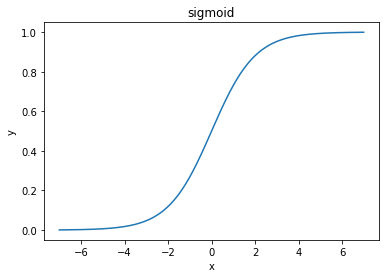

In [82]:
plot_function(sigmoid, "sigmoid")

[0.   0.   0.   ... 6.97 6.98 6.99]


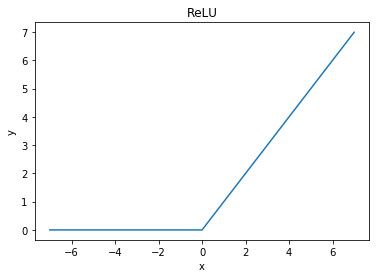

In [83]:
plot_function(relu, "ReLU")

If we compute the gradient for both sigmoid and ReLU, We can get

$$
\frac{\partial sigmoid(z)}{\partial z}=sigmoid(z)*(1-sigmoid(z))
$$
and
$$
\frac{\partial relu(z)}{\partial z}=1(z>0)
$$

In [84]:
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def relu_derivative(z):
    z[z <= 0] = 0
    z[z > 0] = 1
    return z

[0.00091022 0.00091935 0.00092857 ... 0.00093789 0.00092857 0.00091935]


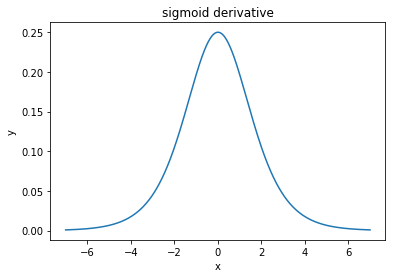

In [85]:
plot_function(sigmoid_derivative, "sigmoid derivative")

[0. 0. 0. ... 1. 1. 1.]


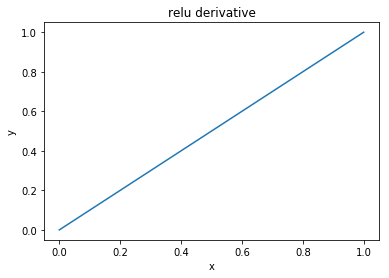

In [88]:
plot_function(relu_derivative, "relu derivative")

You will notice that the derivative of sigmoid never actually goes over 0.25, ReLU on the other hand, has a larger derivative.

Recall that when we update the parameters, 
$$
\theta=\theta-\alpha \frac{\partial Cost}{\partial \theta}
$$

Small $\frac{\partial Cost}{\partial \theta}$ means slow Learning, so that sigmoid is actually not a good option if we want to learn a model fast.

#### Form a Training loop

In [64]:
# initialize parameters randomly
h = 256 # size of hidden layer
W = 0.01 * np.random.randn(784,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,10)
b2 = np.zeros((1,10))

In [65]:
# some hyperparameters
step_size = 1e-3
reg = 1e-3 # regularization strength

In [66]:
# gradient descent loop
for i in tqdm_notebook(range(1000)):
    for idx, (X_batch, y_batch) in enumerate(zip(X_mini_batches, y_mini_batches)):
        loss, probs, hidden_layer = forward(W, b, W2, b2, reg, X_batch, y_batch)
        if i % 50 == 0 and idx == 0:
            print( "iteration %d: loss %f" % (i, loss))

        dW, db, dW2, db2 = backward(W, b, W2, b2, reg, X_batch, hidden_layer, y_batch, probs)
    
        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2

iteration 0: loss 2.311251
iteration 50: loss 0.425484
iteration 100: loss 0.339399
iteration 150: loss 0.311571
iteration 200: loss 0.291808
iteration 250: loss 0.272548
iteration 300: loss 0.254677
iteration 350: loss 0.237345
iteration 400: loss 0.221120
iteration 450: loss 0.205970
iteration 500: loss 0.193160
iteration 550: loss 0.182102
iteration 600: loss 0.172023
iteration 650: loss 0.162890
iteration 700: loss 0.155158
iteration 750: loss 0.148236
iteration 800: loss 0.142088
iteration 850: loss 0.136730
iteration 900: loss 0.132154
iteration 950: loss 0.128225



In [67]:
# Save the trained weight
np.savez('weights.npz', W, b, W2, b2)

In [2]:
weights = np.load('weights.npz')

In [3]:
W, b, W2, b2 = weights['arr_0'], weights['arr_1'], weights['arr_2'], weights['arr_3']

In [70]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print( 'training accuracy: %.4f' % (np.mean(predicted_class == y)))

training accuracy: 0.9727


In [71]:
# evaluate test set accuracy
hidden_layer = np.maximum(0, np.dot(X_test, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print( 'test accuracy: %.4f' % (np.mean(predicted_class == y_test)))

test accuracy: 0.9664


In [94]:
1 - (predicted_class == y_test)

array([0, 0, 0, ..., 0, 0, 0])

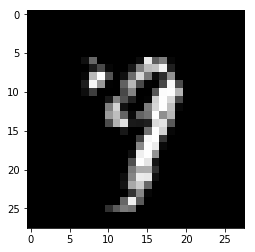

In [99]:
plt.imshow(X_test[(1 - (predicted_class == y_test)).astype(np.bool)][0].reshape((28, 28)), cmap='gray')
plt.show()

In [100]:
y_test[(1 - (predicted_class == y_test)).astype(np.bool)][0]

9.0

In [101]:
predicted_class[(1 - (predicted_class == y_test)).astype(np.bool)][0]

7

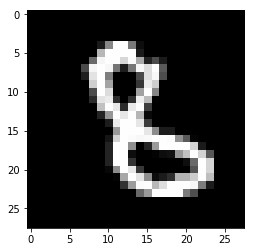

In [11]:
plt.imshow(X[0].reshape((28, 28)), cmap='gray')

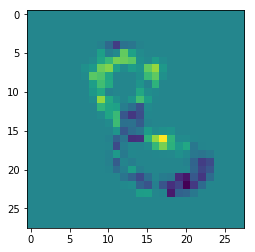

In [12]:
plt.imshow(W[:, 0].reshape((28, 28)) * X[0].reshape((28, 28)))

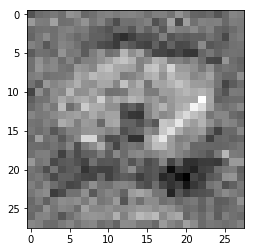

In [15]:
plt.imshow(W[:, 0].reshape((28, 28)), cmap='gray')
plt.show()

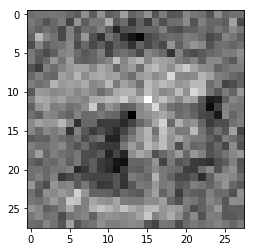

In [111]:
plt.imshow(W[:, 2].reshape((28, 28)), cmap='gray')
plt.show()